<a href="https://colab.research.google.com/github/Elman295/Face_Recognition_by_Multi_Channel_CNN_and_improved_Triplet_loss/blob/main/Face_Recognition_by_Multi_Channel_CNN_and_improved_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import random
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import torch
import torchvision
from torchvision import datasets,transforms
from torch.utils.data import DataLoader, Dataset
from torch import nn
import torch.nn.functional as F

#`Data`

In [ ]:
with zipfile.ZipFile("att_faces.zip","r") as f:
  f.extractall("data")

In [ ]:
data_path = os.path.join("data", "att_faces")

data = datasets.ImageFolder(
    root = data_path
)

In [ ]:
tfms = transforms.Compose([
    transforms.Resize( size = (100,100)),
    transforms.ToTensor()
])

In [ ]:
class Triple_data(Dataset):

  def __init__(self, data, transform = None):
    self.data = data
    self.tfms = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):

    anchor, anchor_label = self.data[idx]

    pos = random.choice([img for img,lbl in self.data if lbl == anchor_label])
    neg = random.choice([img for img,lbl in self.data if lbl != anchor_label])

    anchor = Image.open(anchor).convert("RGB")
    pos = Image.open(pos).convert("RGB")
    neg = Image.open(neg).convert("RGB")

    if self.tfms is not None:
      a = self.tfms(anchor)
      p = self.tfms(pos)
      n = self.tfms(neg)


    return a,p,n

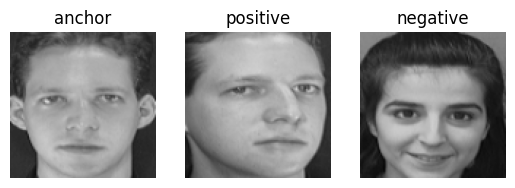

In [ ]:
data_ds = Triple_data(data.imgs, tfms)

a,p,n = data_ds[0]
plt.subplot(1,3,1)
plt.imshow(a.permute(1,2,0))
plt.title("anchor")
plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(p.permute(1,2,0))
plt.title("positive")
plt.axis("off")
plt.subplot(1,3,3)
plt.imshow(n.permute(1,2,0))
plt.title("negative")
plt.axis("off")
plt.show()

In [ ]:
train_ds, test_ds = train_test_split(data_ds, test_size = 0.2)

train_dl = DataLoader(dataset = train_ds, batch_size = 16, shuffle = True)

test_dl = DataLoader(dataset = test_ds, batch_size = 16, shuffle = False)

#`Multi Channel CNN`

In [ ]:
def patchify(data, patch_size = 50):

  b,c,w,h = data.size()
  img1 = data[:,:,:patch_size,:patch_size]
  img2 = data[:,:,: patch_size,patch_size:2*patch_size]
  img3 = data[:,:,patch_size:,:patch_size]
  img4 = data[:,:, patch_size:, patch_size:]

  return img1,img2, img3, img4

In [ ]:
a = a.view((1,3,100,100))
img1, img2, img3, img4 = patchify(a)

In [ ]:
img1.shape

torch.Size([1, 3, 50, 50])

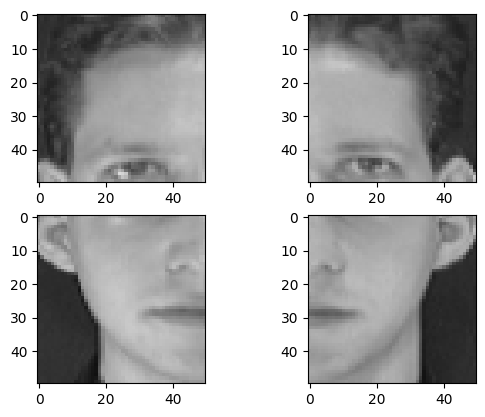

In [ ]:
plt.subplot(2,2,1)
plt.imshow(img1[0].permute(1,2,0))
plt.subplot(2,2,2)
plt.imshow(img2[0].permute(1,2,0))
plt.subplot(2,2,3)
plt.imshow(img3[0].permute(1,2,0))
plt.subplot(2,2,4)
plt.imshow(img4[0].permute(1,2,0))
plt.show()

In [ ]:
class Multi_channel(nn.Module):

  def __init__(self):
    super(Multi_channel, self).__init__()

    self.full_face = nn.Sequential(
        nn.Conv2d(3,3,7,3),
        nn.ReLU()
    )

    self.part_face_1 = nn.Sequential(
        nn.Conv2d(3,32,3,1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )


    self.part_face_2 = nn.Sequential(
        nn.Conv2d(3,32,3,1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )


    self.part_face_3 = nn.Sequential(
        nn.Conv2d(3,32,3,1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )



    self.part_face_4 = nn.Sequential(
        nn.Conv2d(3,32,3,1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )


    self.clf_1 = nn.Sequential(
        nn.Linear(7*7*32,256),
        nn.ReLU(),
        nn.Linear(256,100)
    )


    self.clf_2 = nn.Sequential(
        nn.Linear(7*7*32,256),
        nn.ReLU(),
        nn.Linear(256,100)
    )


    self.clf_3 = nn.Sequential(
        nn.Linear(7*7*32,256),
        nn.ReLU(),
        nn.Linear(256,100)
    )


    self.clf_4 = nn.Sequential(
        nn.Linear(7*7*32,256),
        nn.ReLU(),
        nn.Linear(256,100)
    )


  def forward(self,x):

    f = self.full_face(x)
    f1,f2,f3,f4 = patchify(f,16)
    f1 = self.part_face_1(f1)
    f2 = self.part_face_2(f2)
    f3 = self.part_face_3(f3)
    f4 = self.part_face_4(f4)

    f1 = f1.view((-1,7*7*32))
    f2 = f2.view((-1,7*7*32))
    f3 = f3.view((-1,7*7*32))
    f4 = f4.view((-1,7*7*32))

    f1 = self.clf_1(f1)
    f2 = self.clf_2(f2)
    f3 = self.clf_3(f3)
    f4 = self.clf_4(f4)

    res = torch.cat(tensors = (f1,f2,f3,f4), dim = 1)
    return res

In [ ]:
class Triple(nn.Module):

  def __init__(self, model):
    super(Triple, self).__init__()
    self.model = model

  def forward(self, a,p,n):

    fa = self.model(a)
    fp = self.model(p)
    fn = self.model(n)

    return fa, fp, fn

In [ ]:
model = Multi_channel()

triple = Triple(model)


In [ ]:
opt = torch.optim.Adam(params = triple.parameters(), lr = 1e-3)

#`Improved loss function`

In [ ]:
def L2_distance(p1,p2):
  return F.pairwise_distance(p1,p2)

In [ ]:
def loss_intra_class(fa,fp, margin):

  return torch.mean(torch.clamp(L2_distance(fa,fp) + margin,min = 0))


In [ ]:
loss_triplet = nn.TripletMarginLoss(margin = 1)


#`Train`

In [ ]:
def train(data, model,loss_triplet, loss_intra_class, opt):

  model.train()
  size = len(data.dataset)

  for b , (a,p,n) in enumerate(data):
    fa,fp,fn = model(a,p,n)
    loss_1 = loss_triplet(fa,fp,fn)
    loss_2 = loss_intra_class(fa,fp,1)
    loss = loss_1 + loss_2

    opt.zero_grad()
    loss.backward()
    opt.step()

    if b % 100 == 0:
      print(f"loss: {loss.item()}")

In [ ]:
for e in range(50):
  print(f"epoch:{e+1}=-=-=-=-=-")
  train(train_dl, triple, loss_triplet, loss_intra_class, opt)

epoch:1=-=-=-=-=-
loss: 2.0182852745056152
epoch:2=-=-=-=-=-
loss: 1.599677562713623
epoch:3=-=-=-=-=-
loss: 1.524395227432251
epoch:4=-=-=-=-=-
loss: 1.5794763565063477
epoch:5=-=-=-=-=-
loss: 1.4226469993591309
epoch:6=-=-=-=-=-
loss: 1.418318510055542
epoch:7=-=-=-=-=-
loss: 1.402753233909607
epoch:8=-=-=-=-=-
loss: 1.2815871238708496
epoch:9=-=-=-=-=-
loss: 1.2239183187484741
epoch:10=-=-=-=-=-
loss: 1.2401894330978394
epoch:11=-=-=-=-=-
loss: 1.237646460533142
epoch:12=-=-=-=-=-
loss: 1.2355388402938843
epoch:13=-=-=-=-=-
loss: 1.1567696332931519
epoch:14=-=-=-=-=-
loss: 1.1938656568527222
epoch:15=-=-=-=-=-
loss: 1.3021304607391357
epoch:16=-=-=-=-=-
loss: 1.139500617980957
epoch:17=-=-=-=-=-
loss: 1.1362969875335693
epoch:18=-=-=-=-=-
loss: 1.1502325534820557
epoch:19=-=-=-=-=-
loss: 1.2264655828475952
epoch:20=-=-=-=-=-
loss: 1.2002267837524414
epoch:21=-=-=-=-=-
loss: 1.1823331117630005
epoch:22=-=-=-=-=-
loss: 1.1156481504440308
epoch:23=-=-=-=-=-
loss: 1.1588428020477295
epo

In [ ]:
test_dl = DataLoader(dataset = test_ds, batch_size = 1)

In [ ]:
len(test_dl)

80

In [ ]:
a,p,n = next(iter(test_dl ))
print(a.shape)

triple.eval()

acc= 0

with torch.no_grad():

  for a,p,n in test_dl:
    fa,fp,fn = triple(a,p,n)
    if F.pairwise_distance(fa,fp) < F.pairwise_distance(fa,fn):
      acc+=1

  print(f"accuracy: {(acc / 80)*100}")









torch.Size([1, 3, 100, 100])
accuracy: 100.0
